# Covid-19 nowcasting in Sweden

In [1]:
# The first line is the official data source, but we use Adam Altmejd´s 
# repository for accessing historical data sets.

#filename = "https://www.arcgis.com/sharing/rest/content/items/b5e7488e117749c19881cce45db13f7e/data"
filename = "https://github.com/adamaltmejd/covid/raw/master/data/FHM/Folkhalsomyndigheten_Covid19_2021-01-08.xlsx"

## Load deaths

In [2]:
import pandas as pd

df = pd.read_excel(filename, 
                   sheet_name=1, 
                   parse_dates=['Datum_avliden'])
total_deaths = df.sum()["Antal_avlidna"]

df = df.query('Datum_avliden != "Uppgift saknas"').rename(columns = {"Datum_avliden": "date"})

df.date = pd.to_datetime(df.date, format="")
print("Antal_avlidna:", total_deaths )
print("Uppgift saknas:", total_deaths - df.sum()["Antal_avlidna"] )
df.tail()

Antal_avlidna: 9433
Uppgift saknas: 31


,date,Antal_avlidna
298,2021-01-03,15
299,2021-01-04,16
300,2021-01-05,5
301,2021-01-06,12
302,2021-01-07,0


## Load cases

In [3]:
df2 = pd.read_excel(filename, 
                    sheet_name=0,
                    parse_dates=['Statistikdatum'])
df2 = df2.rename(columns = {"Statistikdatum": "date"})
total_cases = df2.sum()["Totalt_antal_fall"]
print("total_cases:", total_cases )
df2.tail()

total_cases: 489471


,date,Totalt_antal_fall,Blekinge,Dalarna,Gotland,Gävleborg,Halland,Jämtland_Härjedalen,Jönköping,Kalmar,...,Stockholm,Sörmland,Uppsala,Värmland,Västerbotten,Västernorrland,Västmanland,Västra_Götaland,Örebro,Östergötland
334,2021-01-03,2757,184,211,8,10,30,95,272,38,...,161,97,78,111,7,163,4,813,84,67
335,2021-01-04,6984,11,29,23,264,903,8,51,173,...,1096,60,83,16,181,40,249,668,153,420
336,2021-01-05,7553,285,236,36,303,406,119,434,160,...,1315,298,315,89,142,238,172,744,118,267
337,2021-01-06,5037,148,133,27,176,48,98,144,147,...,824,111,221,99,88,139,187,924,111,253
338,2021-01-07,7138,19,24,3,87,443,12,214,249,...,1075,64,98,21,46,76,68,2072,175,202


## Merge the two data frames

In [4]:
df_sweden = df2[['date', 'Totalt_antal_fall']].merge(df, how='left', on="date").rename(columns = {"Antal_avlidna": "new_deaths", "Totalt_antal_fall": "new_cases"})
df_sweden.tail()

,date,new_cases,new_deaths
334,2021-01-03,2757,15.0
335,2021-01-04,6984,16.0
336,2021-01-05,7553,5.0
337,2021-01-06,5037,12.0
338,2021-01-07,7138,0.0


## Prepare for plotting

In [5]:
import matplotlib.pyplot as plt, numpy as np
import matplotlib.ticker as mtick, matplotlib.dates as mdates
from datetime import date

# Retina format increases the resolution of figures in the notebook.
%config InlineBackend.figure_format = 'retina'

# This just removes a warning related to date formatting.
pd.plotting.register_matplotlib_converters()

# The poster format is good for Twitter content. And for posters.
plt.style.use('seaborn-poster')

# This will increase your nerd cred by 200 %
plt.xkcd();

## Plot the plot

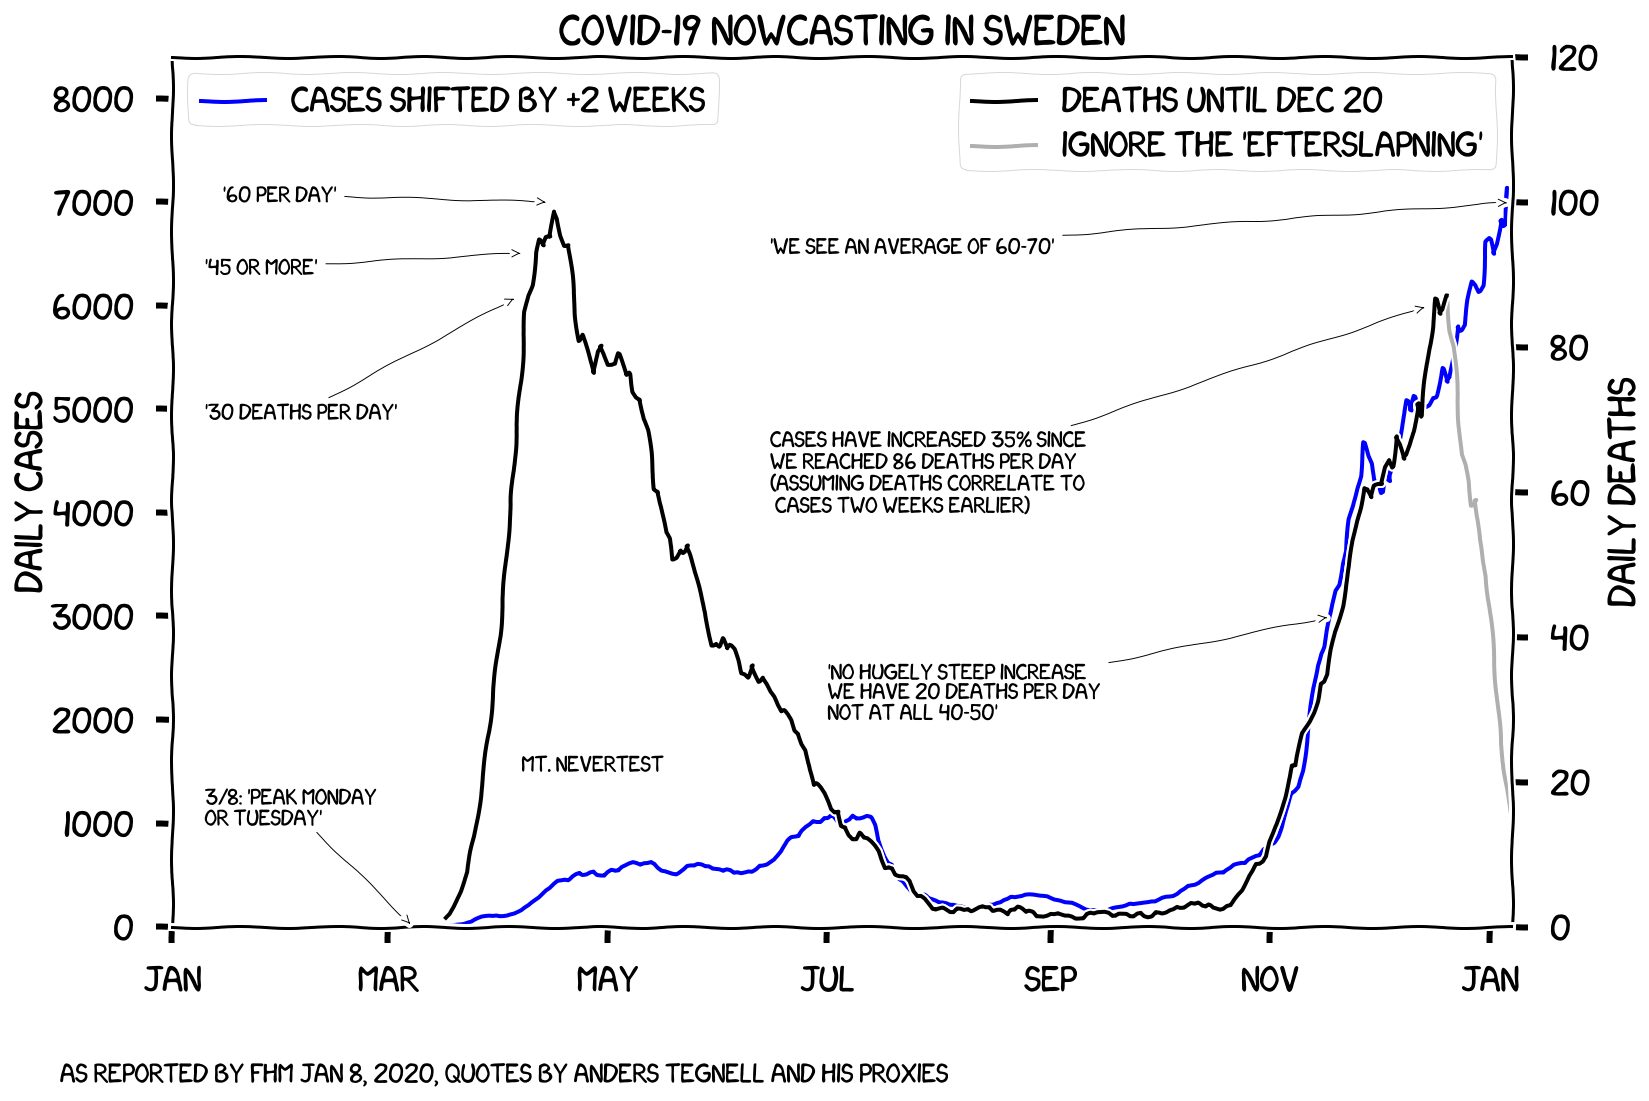

In [6]:
death_truncate = 18

fig = plt.figure(figsize=(12,8)) # Create matplotlib figure

ax1 = fig.add_subplot(111) # Create matplotlib axes

ax1.set_xlim([date(2020, 1, 1), date(2021, 1, 7)])
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.

ax1.plot(df_sweden['date'], 
         df_sweden['new_cases'].shift(14).rolling(7).sum()/7, 
         color='blue', 
         label='Cases shifted by +2 weeks')

ax2.plot( df_sweden['date'], 
         df_sweden['new_deaths'].rolling(7).sum()/7, 
         color='#00000050', 
         label="ignore the 'efterslapning'")

ax2.plot( df_sweden['date'], 
         df_sweden['new_deaths'].shift(death_truncate).shift(-death_truncate).rolling(7).sum()/7, 
         color='black', 
         label='Deaths until Dec 20')

ax1.legend(loc = 2)
handles,labels = ax2.get_legend_handles_labels()
ax2.legend(reversed(handles), reversed(labels), loc = 1)

ax1.set_ylim(0, 120*70)
ax2.set_ylim(0, 120)

ax1.annotate("Mt. Nevertest", (mdates.date2num(date(2020,4,7)), 1500))  
  
    
ax2.annotate("3/8: 'Peak monday\nor tuesday'",
            xy=(mdates.date2num(date(2020,3,8)), 0), xycoords='data',
            xytext=(mdates.date2num(date(2020, 1, 10)), 14), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax2.annotate("'30 deaths per day'",
            xy=(mdates.date2num(date(2020,4,6)), 87), xycoords='data',
            xytext=(mdates.date2num(date(2020, 1, 10)), 70), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax2.annotate("'45 or more'",
            xy=(mdates.date2num(date(2020, 4, 8)), 93), xycoords='data',
            xytext=(mdates.date2num(date(2020, 1, 10)), 90), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax2.annotate("'60 per day'",
            xy=(mdates.date2num(date(2020,4,15)), 100), xycoords='data',
            xytext=(mdates.date2num(date(2020,1,15)), 100), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax1.annotate("Cases have increased 35% since \nwe reached 86 deaths per day\n(Assuming deaths correlate to \n cases two weeks earlier)",
            xy=(mdates.date2num(date(2020,12,15)), 6000), xycoords='data',
            xytext=(mdates.date2num(date(2020,6,15)), 4000), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax1.annotate("'We see an average of 60-70'",
            xy=(mdates.date2num(date(2021,1,7)), 7000), xycoords='data',
            xytext=(mdates.date2num(date(2020,6,15)), 6500), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax1.annotate("'No hugely steep increase\nWe have 20 deaths per day\nNot at all 40-50'",
            xy=(mdates.date2num(date(2020,11,18)), 3000), xycoords='data',
            xytext=(mdates.date2num(date(2020,7,1)), 2000), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.set_ylabel("Daily cases")
ax2.set_ylabel("Daily deaths")
plt.title("Covid-19 nowcasting in Sweden")

plt.figtext(0.06, -0.01, "As reported by FHM Jan 8, 2020, Quotes by Anders Tegnell and his proxies", ha = "left", fontsize=12)
plt.savefig('100_deaths.png', dpi=300, figsize=(12,8));